# Stable Diffusion from scratch

## Deep Learning 2025

### [Nicola Dall'Asen](https://fodark.xyz/)
#### nicola.dallasen@unitn.it

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

Adaptation of the notebook from Binxu Wang and John Vastola.

We went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/).

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, we will have a working Stable-Diffusion-like model.

In particular, we will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4.

----------------

In [ ]:
!pip install einops
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 714.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 472.9 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid

-------------------------------------------

## 1. Basic forward/reverse diffusion

### Extremely good references:
- [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/)
- [SCORE-BASED GENERATIVE MODELING THROUGH STOCHASTIC DIFFERENTIAL EQUATIONS](https://openreview.net/pdf?id=PxTIG12RRHS)

The gist is that our generative model will work in the following way. We will take our training examples (e.g. images) and corrupt them with noise until they are unrecognizable. Then we will learn to `denoise' them, and potentially turn pure noise into something similar to what we started with.

### Basic forward diffusion

**Let's start with forward diffusion.** In the simplest case, the relevant diffusion equation is
\begin{equation}
\begin{split}
q(x_t|x_0) &= \mathcal{N}(\sqrt{\bar{\alpha_t}} x_0, (1 - \bar{\alpha_t}) \mathbf{I}) \\
\end{split}
\end{equation}
where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha_t} = \prod_{i=1}^t \alpha_i$.

$\beta_t$ is the noise schedule, which is a function of $t$ that determines how much noise to add at each step. For now, we will use a linear schedule.

In [ ]:
import numpy as np

beta_min = 1e-4
beta_max = 0.02

num_steps = 500
device = "cuda" if torch.cuda.is_available() else "cpu"

betas = np.linspace(beta_min, beta_max, num_steps)
betas = torch.from_numpy(betas).float().to(device)

alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
log_one_minus_alphas_cumprod = torch.log(1.0 - alphas_cumprod)
sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod - 1)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
posterior_log_variance_clipped = torch.log(posterior_variance.clamp(min=1e-20))
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
posterior_mean_coef2 = (
    (1.0 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - alphas_cumprod)
)

In [ ]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def predict_start_from_noise(x_t, t, noise):
    return (
        extract(sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
        - extract(sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
    )


def model_predictions(x, t, score_model, y=None):
    model_output = score_model(x, t, y=y)

    pred_noise = model_output
    x_start = predict_start_from_noise(x, t, pred_noise)

    return x_start, pred_noise


def q_posterior(x_start, x_t, t):
    posterior_mean = (
        extract(posterior_mean_coef1, t, x_t.shape) * x_start
        + extract(posterior_mean_coef2, t, x_t.shape) * x_t
    )
    posterior_v = extract(posterior_variance, t, x_t.shape)
    posterior_log_v_clipped = extract(posterior_log_variance_clipped, t, x_t.shape)
    return posterior_mean, posterior_v, posterior_log_v_clipped


def p_mean_variance(x, t, score_model, clip_denoised=True, y=None):
    x_start, _ = model_predictions(x, t, score_model, y=y)

    if clip_denoised:
        x_start.clamp_(-1.0, 1.0)

    model_mean, posterior_v, posterior_log_v = q_posterior(x_start=x_start, x_t=x, t=t)
    return model_mean, posterior_v, posterior_log_v, x_start


@torch.no_grad()
def p_sample(x, t: int, score_model, y=None):
    b = x.shape[0]
    batched_times = torch.full((b,), t, device=device, dtype=torch.long)
    model_mean, _, model_log_variance, x_start = p_mean_variance(
        x=x, t=batched_times, score_model=score_model, clip_denoised=True, y=y
    )
    noise = torch.randn_like(x) if t > 0 else 0.0  # no noise if t == 0
    pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
    return pred_img, x_start


@torch.no_grad()
def p_sample_loop(score_model, shape, return_all_timesteps=False, y=None):
    batch = shape[0]

    img = torch.randn(shape, device=device)
    imgs = [img]

    x_start = None

    for t in tqdm(
        reversed(range(0, num_steps)), desc="sampling loop time step", total=num_steps
    ):
        img, x_start = p_sample(img, t, score_model, y=y)
        imgs.append(img)

    ret = img if not return_all_timesteps else torch.stack(imgs, dim=1)

    return ret

In [ ]:
# Simulate forward diffusion for N steps.
def forward_diffusion_1D(x0):
    """x0: initial sample value, scalar
    noise_strength_fn: function of time, outputs scalar noise strength
    t0: initial time
    nsteps: number of diffusion steps
    dt: time step size
    """

    # Initialize trajectory
    x = np.zeros(num_steps + 1)
    x[0] = x0

    # Simulate forward diffusion
    for i in range(num_steps):
        x[i + 1] = sqrt_alphas_cumprod[i] * x0 + sqrt_one_minus_alphas_cumprod[
            i
        ] * np.random.normal(0, 1)

    return x


# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    return 1

See if it works by running the code below.

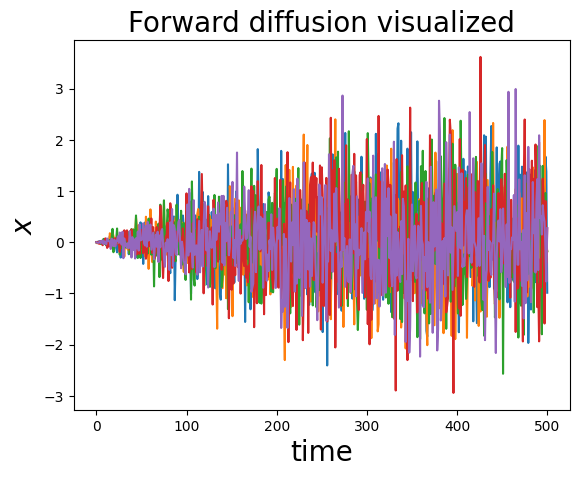

In [ ]:
# nsteps = 100
# t0 = 0
# dt = 0.1
# noise_strength_fn = noise_strength_constant
x0 = 0

num_tries = 5
for i in range(num_tries):
    x = forward_diffusion_1D(x0)

    plt.plot(np.arange(num_steps + 1), x)
    plt.xlabel("time", fontsize=20)
    plt.ylabel("$x$", fontsize=20)
plt.title("Forward diffusion visualized", fontsize=20)
plt.show()

### Basic score function learning

In practice, we don't already know the score function; instead, we have to learn it. One way to learn it is to train a neural network to `denoise' samples via the denoising objective
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0)}\left[ \ \Vert s(x_{noised}, t) \sigma^2(t) + (x_{noised} - x_0)  \Vert^2_2  \ \right]
\end{equation}
where $p_0(x_0)$ is our target distribution (e.g. pictures of cats and dogs), and where $x_{noised}$ is the target distribution sample $x_0$ after one forward diffusion step, i.e. $x_{noised} - x_0$ is just a normally-distributed random variable.

Here's another way of writing the same thing:
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert s(x_0 + \sigma(t) \epsilon, t) \sigma^2(t) + \epsilon  \Vert^2_2  \ \right]
\end{equation}

Which, reformualated as $\epsilon$-prediction, becomes:

\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert \epsilon_{\theta}(x_t, t) - \epsilon  \Vert^2  \ \right]
\end{equation}

We will implement this for you. But it's good to understand the intuition: we are learning to predict **how much noise was added to each part of our sample**. We should be able to do this well at every time $t$ in the diffusion process, and for every $x_0$ in our original (dogs/cats/etc) distribution.

---------------------

## 2. Working with images via U-Nets

We just reviewed the very basics of diffusion models, with the takeaway that learning the score function allows us to turn pure noise into something interesting. We will learn to approximate the score function with a neural network. But when we are working with images, we need our neural network to 'play nice' with them, and to reflect inductive biases we associate with images.

A reasonable choice is to choose the neural network architecture to be that of a [U-Net](https://en.wikipedia.org/wiki/U-Net), which combines a CNN-like structure with downscaling/upscaling operations that help the network pay attention to features of images at different spatial scales.  

Since the score function we're trying to learn is a function of time, we also need to come up with a way to make sure our neural network properly responds to changes in time. For this purpose, we can use a **time embedding**.

### Helping our neural network work with time

The below code helps our neural network work with time via a **time embedding**. The idea is that, instead of just telling our network one number (the current time), we express the current time in terms of a large number of sinusoidal features. The hope is that, if we tell our network the current time in many different ways, it will more easily respond to changes in time.

This will enable us to successfully learn a time-dependent score function $\epsilon_{\theta}(x, t)$.

In [ ]:
# @title Get some modules to let time interact


class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.0):
        super().__init__()
        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        # Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps.
    Allow time repr to input additively from the side of a convolution layer.
    """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]
        # this broadcast the 2d tensor to 4d, add the same value across space.

### Defining the U-Net architecture

In [ ]:
# @title Defining a time-dependent score-based model (double click to expand or collapse)


class UNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False
        )
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2] + channels[2],
            channels[1],
            3,
            stride=2,
            bias=False,
            output_padding=1,
        )
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1] + channels[1],
            channels[0],
            3,
            stride=2,
            bias=False,
            output_padding=1,
        )
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t, y=None):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        ## Incorporate information from t
        ## Group normalization
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        # h3 = ...  # conv, dense
        #   apply activation function
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        ############
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(torch.cat([h, h1], dim=1))

        return h

Below is code for an alternate U-Net architecture. Apparently, diffusion models can be successful with somewhat different architectural details. (Note that the differences from the above class are kind of subtle, though.)

* Upper one, **concatenate the tensor from the down block** for skip connection.
* Lower one, directly **add the tensor from the down blocks** for skip connection.
  * A special case of the upper

In [ ]:
# @title Alternative time-dependent score-based model (double click to expand or collapse)


class UNet_res(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False
        )
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2], channels[1], 3, stride=2, bias=False, output_padding=1
        )  #  + channels[2]
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1], channels[0], 3, stride=2, bias=False, output_padding=1
        )  #  + channels[1]
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)  #  + channels[0]

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t, y=None):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        ## Incorporate information from t
        ## Group normalization
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        return h

**Tips**: When you feel uncertain about the shape of the tensors throughout the layers, define the layers outside and see the shapes. This format could be helpful.

In [ ]:
net = nn.Sequential(
    nn.Conv2d(...),
    nn.ConvTranspose2d(...),
)
x = torch.randn(...)
for l in net:
    x = layer(x)
    print(x.shape)

----------------

## 3. Train the U-Net to learn a score function

Let's combine the U-Net we just defined with a way to learn the score function. We need to define a loss function, and then train a neural network in the usual way.

### Defining the loss function

The loss function is mostly defined below. **You need to add one part**: sample random noise with strength `std[:, None, None, None]`, and make sure it has the same shape as $\mathbf{x}$. Then use this to perturb $\mathbf{x}$.

*Hint: `torch.randn_like()` may be useful.*

In [ ]:
def loss_fn(model, x):
    """The loss function for training score-based generative models.

    Args:
      model: A PyTorch model instance that represents a
        time-dependent score-based model.
      x: A mini-batch of training data.
    """
    # Sample time uniformly in 0, num_steps
    random_t = torch.randint(low=0, high=num_steps, size=(x.shape[0],), device=device)
    z = torch.randn_like(x)  # get normally distributed noise

    perturbed_x = (
        sqrt_alphas_cumprod[random_t][..., None, None, None] * x
        + sqrt_one_minus_alphas_cumprod[random_t][..., None, None, None] * z
    )
    eps = model(perturbed_x, random_t)
    loss = torch.mean((eps - z) ** 2)
    return loss

### Training on MNIST

We will train on MNIST, and learn to generate pictures that look like 0-9 digits. No code to fill in here; just run it and see if it works!

In [ ]:
# @title Training (double click to expand or collapse)

score_model = UNet()
score_model = score_model.to(device)

n_epochs = 20  # @param {'type':'integer'}
## size of a mini-batch
batch_size = 2048  # @param {'type':'integer'}
## learning rate
lr = 5e-4  # @param {'type':'number'}

dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in tqdm(data_loader):
        x = x.to(device)
        loss = loss_fn(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt.pth")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 39901676.32it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1098666.70it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2266657.42it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9288409.93it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# @title Training the alternate U-Net model (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet_res())
score_model = score_model.to(device)

n_epochs = 50  # @param {'type':'integer'}
## size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
## learning rate
lr = 10e-4  # @param {'type':'number'}

dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98**epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print(
        "{} Average Loss: {:5f} lr {:.1e}".format(
            epoch, avg_loss / num_items, lr_current
        )
    )
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt_res.pth")

Visualize the results of training below.

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

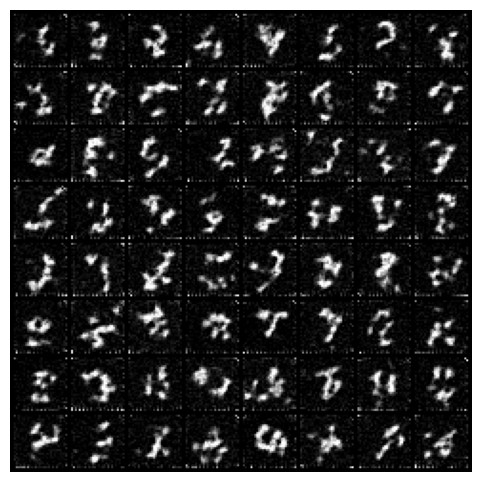

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

## Load the pre-trained checkpoint from disk.
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

sample_batch_size = 64  # @param {'type':'integer'}

samples = p_sample_loop(
    score_model, (sample_batch_size, 1, 28, 28), return_all_timesteps=False
)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)

sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0.0, vmax=1.0)
plt.show()

----------------------

## 4. Using attention to get conditional generation to work

In addition to generating images of e.g. 0-9 digits, we would like to do *conditional* generation: we would like to *specify* which digit we would like to generate an image of, for example.

Attention models, while not strictly necessary for conditional generation, have proven useful for getting it to work well.

In [ ]:
from einops import rearrange
import math

### "Word embedding" of digits

Here, instead of using a fancy CLIP model, we just define our own vector representations of the digits 0-9.

We used the `nn.Embedding` layer to turn 0-9 index into vectors.

In [ ]:
class WordEmbed(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(WordEmbed, self).__init__()
        self.embed = nn.Embedding(vocab_size + 1, embed_dim)

    def forward(self, ids):
        return self.embed(ids)

### Let's develop our Attention layer

We usually implement attention models using 3 parts:
* `CrossAttention`  Write a module to do self / cross attention for **sequences**.
* `TransformerBlock`  Combine self/cross-attention and a feed-forward neural network.
* `SpatialTransformer`  To use attention in a U-net, transform the spatial tensor to a sequential tensor and back.

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/attention_pic1.png?raw=true" alt="drawing" width="850"/>
</p>

Here's a brief review of the mathematics of attention models. [QKV (query-key-value) attention models](https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms) represent queries, keys, and values as vectors. These are tools that help us relate words/images on one side of a translation task to the other side.

These are linearly related to $\mathbf{e}$ vectors (which represent the hidden state of the encoder) and $\mathbf{h}$ vectors (which represent the hidden state of the decoder):

\begin{equation}
\begin{split}
\mathbf{q}_i &= W_q \mathbf{h}_i \\
\mathbf{k}_j &= W_k \mathbf{e}_j \\
\mathbf{v}_j &= W_v \mathbf{e}_j \ .
\end{split}
\end{equation}

To figure out what to 'pay attention' to, we compute the inner product (i.e. similarity) of each key $\mathbf{k}$ and query $\mathbf{q}$. To get typical values that are not too big or too small, we normalize by the length/dimension of the query vectors $\mathbf{q}_i$.

The final attention distribution comes from softmax-ing all of this:

\begin{equation}
\begin{split}
a_{ij} &= \text{SoftMax}\left( \frac{\mathbf{k}_j \cdot \mathbf{q}_i}{\sqrt{\text{len}(\mathbf{q}_i)}} \right) \\
\sum_j a_{ij} &= 1
\end{split}
\end{equation}

The attention distribution is used to pick out some relevant combination of features. For example, in translating the phrase "European Union" from English to French, getting the correct answer ("Union européenne") requires paying attention to both words at once, instead of trying to translate each word totally separately. Mathematically, we weight values $\mathbf{v}_j$ by the attention distribution:

\begin{equation}
\mathbf{c}_i := \sum_j a_{ij} \mathbf{v}_j
\end{equation}

Note that the relevant matrix multiplications can be performed using `torch.einsum`. For example, to multiply an $M \times N$ matrix $A$ together with an $N \times N$ matrix $B$, i.e. to obtain $A B$, we can write:

`torch.einsum(ij,jk -> ik ,A, B)`

If, instead, we wanted to compute $A B^T$, we could write

`torch.einsum(ij,kj->ik ,A, B)`

The library takes care of moving the dimensions around properly. For machine learning, it is often important to do operations like matrix multiplication in batches. In this case, you can might have tensors instead of matrices, but you can write a very similar expression:

`torch.einsum(bij,bkj ,A, B)`

where `b` here is the index that describes which batch elements we are talking about. As a final point, you can use whatever letters you like instead of `i`, `j`, etc.

*Hint: `F.softmax` may also be helpful!*

### Attention Modules

In [ ]:
class CrossAttention(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        context_dim=None,
        num_heads=1,
    ):
        """
        Note: For simplicity reason, we just implemented 1-head attention.
        Feel free to implement multi-head attention! with fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)  ###########
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)  #############
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)  ############

    def forward(self, tokens, context=None):
        # tokens: with shape [batch, sequence_len, hidden_dim]
        # context: with shape [batch, contex_seq_len, context_dim]
        if self.self_attn:
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # implement Q, K, V for the Cross attention
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)
        # print(Q.shape, K.shape, V.shape)
        scoremats = torch.einsum(
            "BTH,BSH->BTS", Q, K
        )  # inner product of Q and K, a tensor
        attnmats = F.softmax(
            scoremats / np.sqrt(self.embed_dim), dim=-1
        )  # softmax of scoremats
        # print(scoremats.shape, attnmats.shape, )
        ctx_vecs = torch.einsum(
            "BTS,BSH->BTH", attnmats, V
        )  # weighted average value vectors by attnmats
        return ctx_vecs


class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn and feed forward neural net"""

    def __init__(self, hidden_dim, context_dim):
        super(TransformerBlock, self).__init__()
        self.attn_self = CrossAttention(
            hidden_dim,
            hidden_dim,
        )
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim),
        )

    def forward(self, x, context=None):
        # Notice the + x as residue connections
        x = self.attn_self(self.norm1(x)) + x
        # Notice the + x as residue connections
        x = self.attn_cross(self.norm2(x), context=context) + x
        # Notice the + x as residue connections
        x = self.ffn(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        b, c, h, w = x.shape
        x_in = x
        # Combine the spatial dimensions and move the channel dimen to the end
        x = rearrange(x, "b c h w->b (h w) c")
        # Apply the sequence transformer
        x = self.transformer(x, context)
        # Reverse the process
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        # Residue
        return x + x_in

### Putting it together, UNet Transformer

Now you can interleave your `SpatialTransformer` layers with the convolutional layers!

Remember to use them in your forward function. **Look at the architecture, and add in extra attention layers if you wish.**

In [ ]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(
        self,
        channels=[32, 64, 128, 256],
        embed_dim=256,
        text_dim=256,
        nClass=10,
    ):
        """Initialize a time-dependent score-based network.

        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings of time.
          text_dim:  the embedding dimension of text / digits.
          nClass:    number of classes you want to model.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(
            channels[3], text_dim
        )  ######################################

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False
        )
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(
            channels[2], channels[1], 3, stride=2, bias=False, output_padding=1
        )  #  + channels[2]
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(
            channels[1], channels[0], 3, stride=2, bias=False, output_padding=1
        )  #  + channels[1]
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)  #  + channels[0]

        # The swish activation function
        self.act = nn.SiLU()  # lambda x: x * torch.sigmoid(x)
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)
        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        ## Incorporate information from t
        ## Group normalization
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)  # Use your attention layers
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(
            h4, y_embed
        )  ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        ## Skip connection from the encoding path
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        return h

### Conditional Denoising Loss

Here, we need to modify the loss function by using the `y` information in the training.

In [ ]:
def loss_fn_cond(model, x, y):
    """The loss function for training score-based generative models.

    Args:
      model: A PyTorch model instance that represents a
        time-dependent score-based model.
      x: A mini-batch of training data.
    """

    # Sample time uniformly in 0, num_steps
    random_t = torch.randint(low=0, high=num_steps, size=(x.shape[0],), device=device)
    z = torch.randn_like(x)  # get normally distributed noise
    # perturbed_x = one_minus_betas_sqrt[random_t][..., None, None, None] * x + betas[random_t][..., None, None, None] * z
    perturbed_x = (
        sqrt_alphas_cumprod[random_t][..., None, None, None] * x
        + sqrt_one_minus_alphas_cumprod[random_t][..., None, None, None] * z
    )
    eps = model(perturbed_x, random_t, y=y)
    loss = torch.mean((eps - z) ** 2)
    return loss

### Training a model that includes attention

The below code, similar to code above, does the training.

In [ ]:
# @title Training model

continue_training = False  # @param {type:"boolean"}
if not continue_training:
    print("initilize new score model...")
    score_model = torch.nn.DataParallel(UNet_Tranformer())
    score_model = score_model.to(device)


n_epochs = 10  # @param {'type':'integer'}
## size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
## learning rate
lr = 10e-4  # @param {'type':'number'}

dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98**epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in tqdm(data_loader):
        x = x.to(device)
        loss = loss_fn_cond(score_model, x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print(
        "{} Average Loss: {:5f} lr {:.1e}".format(
            epoch, avg_loss / num_items, lr_current
        )
    )
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt_transformer.pth")

initilize new score model...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

0 Average Loss: 1.188435 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 0.318370 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 0.214157 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 0.172148 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 0.147076 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 0.127643 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 0.115346 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 0.105359 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 0.097002 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 0.090114 lr 8.2e-04


In [ ]:
# @title A handy training function
def train_diffusion_model(
    dataset,
    score_model,
    n_epochs=100,
    batch_size=1024,
    lr=10e-4,
    model_name="transformer",
):
    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=4
    )

    optimizer = Adam(score_model.parameters(), lr=lr)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98**epoch))
    tqdm_epoch = trange(n_epochs)
    for epoch in tqdm_epoch:
        avg_loss = 0.0
        num_items = 0
        for x, y in tqdm(data_loader):
            x = x.to(device)
            loss = loss_fn_cond(score_model, x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        scheduler.step()
        lr_current = scheduler.get_last_lr()[0]
        print(
            "{} Average Loss: {:5f} lr {:.1e}".format(
                epoch, avg_loss / num_items, lr_current
            )
        )
        # Print the averaged training loss so far.
        tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
        # Update the checkpoint after each epoch of training.
        torch.save(score_model.state_dict(), f"ckpt_{model_name}.pth")

In [ ]:
# Feel free to play with hyperparameters for training!
score_model = torch.nn.DataParallel(UNet_Tranformer())
score_model = score_model.to(device)
train_diffusion_model(
    dataset,
    score_model,
    n_epochs=50,
    batch_size=1024,
    lr=10e-4,
    model_name="transformer",
)

In [ ]:
def visualize_digit_embedding(digit_embed):
    cossim_mat = []
    for i in range(10):
        cossim = torch.cosine_similarity(digit_embed, digit_embed[i : i + 1, :]).cpu()
        cossim_mat.append(cossim)
    cossim_mat = torch.stack(cossim_mat)
    cossim_mat_nodiag = cossim_mat + torch.diag_embed(torch.nan * torch.ones(10))
    plt.imshow(cossim_mat_nodiag)
    plt.legend()
    plt.show()
    return cossim_mat

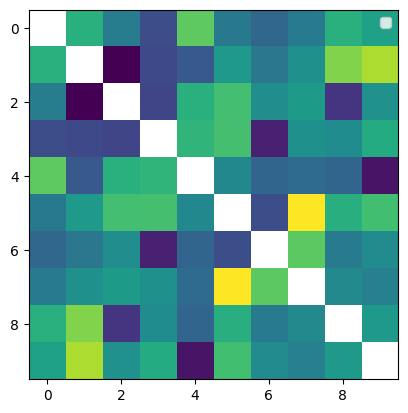

In [ ]:
cossim_mat = visualize_digit_embedding(score_model.module.cond_embed.weight.data)

### Examine Samples

Here is some code we can use to see how well the model does conditional generation. You can use the menu on the right to choose what you want to generate.

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

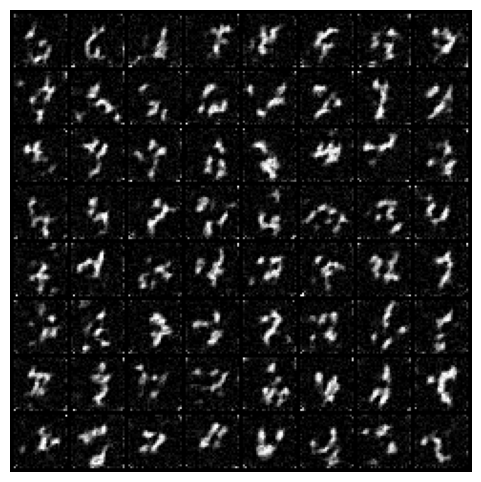

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

## Load the pre-trained checkpoint from disk.
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

digit = 7  # @param {'type':'integer'}
y = digit * torch.ones(sample_batch_size, dtype=torch.long)
sample_batch_size = 64  # @param {'type':'integer'}

samples = p_sample_loop(
    score_model, (sample_batch_size, 1, 28, 28), y=y, return_all_timesteps=False
)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)


sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0.0, vmax=1.0)
plt.show()

--------------------

## 5. Latent space diffusion using an autoencoder

Finally, we get to one of the most important contributions of [Rombach et al.](https://ommer-lab.com/research/latent-diffusion-models/), the paper behind Stable Diffusion! Instead of diffusing in pixel space (i.e. corrupting and denoising each pixel of an image), we can try diffusing in some kind of *latent space*.

This has a few advantages. An obvious one is speed: compressing images before doing forward/reverse diffusion on them makes both generation and training faster. Another advantage is that the latent space, if carefully chosen, may be a more natural or interpretable space for working with images. For example, given a set of pictures of heads, perhaps some latent direction corresponds to head direction.

If we do not have any a priori bias towards one latent space or another, we can just throw an autoencoder at the problem and hope it comes up with something appropriate.

In this section, **we will use an autoencoder to compress MNIST images to a smaller scale**, and glue this to the rest of our diffusion pipeline.

### Defining the autoencoder

**Complete the missing part of the autoencoder's forward function**. Note that what an autoencoder does is first 'encode' an image into some latent representation, and then 'decode' an image from that latent representation.

*Hint: You can access the encoder and decoder via `self.encoder` and `self.decoder`.*

In [ ]:
class AutoEncoder(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(
        self,
        channels=[4, 8, 32],
    ):
        """Initialize a time-dependent score-based network.
        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        # Encoding layers where the resolution decreases
        self.encoder = nn.Sequential(
            nn.Conv2d(1, channels[0], 3, stride=1, bias=True),
            nn.BatchNorm2d(channels[0]),
            nn.SiLU(),
            nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=True),
            nn.BatchNorm2d(channels[1]),
            nn.SiLU(),
            nn.Conv2d(channels[1], channels[2], 3, stride=1, bias=True),
            nn.BatchNorm2d(channels[2]),
        )  # nn.SiLU(),
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(channels[2], channels[1], 3, stride=1, bias=True),
            nn.BatchNorm2d(channels[1]),
            nn.SiLU(),
            nn.ConvTranspose2d(
                channels[1], channels[0], 3, stride=2, bias=True, output_padding=1
            ),
            nn.BatchNorm2d(channels[0]),
            nn.SiLU(),
            nn.ConvTranspose2d(channels[0], 1, 3, stride=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.decoder(self.encoder(x))

        return output

The following code checks to see whether your autoencoder was defined properly.

In [ ]:
x_tmp = torch.randn(1, 1, 28, 28)
print(AutoEncoder()(x_tmp).shape)
assert (
    AutoEncoder()(x_tmp).shape == x_tmp.shape
), "Check conv layer spec! the autoencoder input output shape not align"

torch.Size([1, 1, 28, 28])


### Train the autoencoder with the help of a perceptual loss

Let's train the autoencoder on MNIST images! Do this by running the cells below.

The loss could be really small ~ close to 0.01

In [ ]:
from lpips import LPIPS

In [ ]:
# Define the loss function, MSE and LPIPS
lpips = LPIPS(net="squeeze").to(device)
loss_fn_ae = (
    lambda x, x_hat: nn.functional.mse_loss(x, x_hat)
    + lpips(x.repeat(1, 3, 1, 1), x_hat.repeat(1, 3, 1, 1)).mean()
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


100%|██████████| 4.73M/4.73M [00:00<00:00, 47.1MB/s]

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/squeeze.pth


In [ ]:
ae_model = AutoEncoder([4, 4, 4]).to(device)
n_epochs = 50  # @param {'type':'integer'}
## size of a mini-batch
batch_size = 2048  # @param {'type':'integer'}
## learning rate
lr = 10e-4  # @param {'type':'number'}

dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

optimizer = Adam(ae_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in tqdm(data_loader):
        x = x.to(device)
        z = ae_model.encoder(x)
        x_hat = ae_model.decoder(z)
        loss = loss_fn_ae(x, x_hat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    print("{} Average Loss: {:5f}".format(epoch, avg_loss / num_items))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(ae_model.state_dict(), "ckpt_ae.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 Average Loss: 0.505194


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
x_hat.shape

The below cell visualizes the results. The autoencoder's output should look almost identical to the original images.

In [ ]:
# @title Visualize trained autoencoder
ae_model.eval()
x, y = next(iter(data_loader))
x_hat = ae_model(x.to(device)).cpu()
plt.figure(figsize=(6, 6.5))
plt.axis("off")
plt.imshow(make_grid(x[:64, :, :, :].cpu()).permute([1, 2, 0]), vmin=0.0, vmax=1.0)
plt.title("Original")
plt.show()

plt.figure(figsize=(6, 6.5))
plt.axis("off")
plt.imshow(make_grid(x_hat[:64, :, :, :].cpu()).permute([1, 2, 0]), vmin=0.0, vmax=1.0)
plt.title("AE Reconstructed")
plt.show()

### Create latent state dataset

Let's use our autoencoder to convert MNIST images into a latent space representation. We will use these compressed images to train our diffusion generative model.

In [ ]:
batch_size = 4096
dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
ae_model.requires_grad_(False)
ae_model.eval()
zs = []
ys = []
for x, y in tqdm(data_loader):
    z = ae_model.encoder(x.to(device)).cpu()
    zs.append(z)
    ys.append(y)

zdata = torch.cat(
    zs,
)
ydata = torch.cat(
    ys,
)

In [ ]:
print(zdata.shape)
print(ydata.shape)
print(zdata.mean(), zdata.var())

In [ ]:
from torch.utils.data import TensorDataset

latent_dataset = TensorDataset(zdata, ydata)

### Transformer UNet model for Latents

Here is a U-Net (that includes self/cross-attention) similar to the one we defined before, but that this time works with compressed images instead of full-size images. You don't need to do anything here except take a look at the architecture.

In [ ]:
class Latent_UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(
        self,
        channels=[4, 64, 128, 256],
        embed_dim=256,
        text_dim=256,
        nClass=10,
    ):
        """Initialize a time-dependent score-based network.

        Args:
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(channels[0], channels[1], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[1])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[1])
        self.conv2 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[2])
        self.gnorm2 = nn.GroupNorm(4, num_channels=channels[2])
        self.attn2 = SpatialTransformer(channels[2], text_dim)
        self.conv3 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[3])
        self.gnorm3 = nn.GroupNorm(4, num_channels=channels[3])
        self.attn3 = SpatialTransformer(channels[3], text_dim)

        self.tconv3 = nn.ConvTranspose2d(
            channels[3],
            channels[2],
            3,
            stride=2,
            bias=False,
        )
        self.dense6 = Dense(embed_dim, channels[2])
        self.tgnorm3 = nn.GroupNorm(4, num_channels=channels[2])
        self.attn6 = SpatialTransformer(channels[2], text_dim)
        self.tconv2 = nn.ConvTranspose2d(
            channels[2], channels[1], 3, stride=2, bias=False, output_padding=1
        )  # + channels[2]
        self.dense7 = Dense(embed_dim, channels[1])
        self.tgnorm2 = nn.GroupNorm(4, num_channels=channels[1])
        self.tconv1 = nn.ConvTranspose2d(
            channels[1], channels[0], 3, stride=1
        )  # + channels[1]

        # The swish activation function
        self.act = nn.SiLU()  # lambda x: x * torch.sigmoid(x)
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)
        # Encoding path
        ## Incorporate information from t
        h1 = self.conv1(x) + self.dense1(embed)
        ## Group normalization
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h2 = self.attn2(h2, y_embed)
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)

        # Decoding path
        ## Skip connection from the encoding path
        h = self.tconv3(h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.attn6(h, y_embed)
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        return h

### Training our latent diffusion model

Finally, we will put everything together, and combine our latent space representation with our fancy U-Net for learning the score function. (This may not actually work that well...but at least you can appreciate that, with all these moving parts, this becomes a hard engineering problem.)

Run the cell below to train our latent diffusion model!

In [ ]:
# @title Training Latent diffusion model

continue_training = False  # @param {type:"boolean"}
if not continue_training:
    print("initilize new score model...")
    latent_score_model = torch.nn.DataParallel(
        Latent_UNet_Tranformer(
            channels=[4, 16, 32, 64],
        )
    )
    latent_score_model = latent_score_model.to(device)


n_epochs = 10  # @param {'type':'integer'}
## size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
## learning rate
lr = 1e-4  # @param {'type':'number'}

latent_data_loader = DataLoader(
    latent_dataset,
    batch_size=batch_size,
    shuffle=True,
)
latent_score_model.train()
optimizer = Adam(latent_score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995**epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for z, y in latent_data_loader:
        z = z.to(device)
        y = y.to(device)
        loss = loss_fn_cond(latent_score_model, z, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * z.shape[0]
        num_items += z.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print(
        "{} Average Loss: {:5f} lr {:.1e}".format(
            epoch, avg_loss / num_items, lr_current
        )
    )
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(latent_score_model.state_dict(), "ckpt_latent_diff_transformer.pth")

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

latent_score_model.eval()

## Load the pre-trained checkpoint from disk.
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

digit = 4  # @param {'type':'integer'}
y = digit * torch.ones(sample_batch_size, dtype=torch.long, device=device)
sample_batch_size = 64  # @param {'type':'integer'}


## Generate samples using the specified sampler.
samples_z = p_sample_loop(
    latent_score_model, (sample_batch_size, 4, 10, 10), y=y, return_all_timesteps=False
)


## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))


plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
# play with architecturs
latent_score_model = torch.nn.DataParallel(
    Latent_UNet_Tranformer(
        channels=[4, 16, 32, 64],
    )
)
latent_score_model = latent_score_model.to(device)

train_diffusion_model(
    latent_dataset,
    score_model,
    n_epochs=100,
    batch_size=1024,
    lr=10e-4,
    model_name="transformer_latent",
)

### Examine Samples

Below, we examine some samples in more detail to study the image generation quality. You may see some pretty weird stuff here.

In [ ]:
cossim_mat = visualize_digit_embedding(latent_score_model.module.cond_embed.weight.data)

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

## Load the pre-trained checkpoint from disk.
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)

digit = 8  # @param {'type':'integer'}
y = digit * torch.ones(sample_batch_size, dtype=torch.long)
sample_batch_size = 64  # @param {'type':'integer'}


## Generate samples using the specified sampler.
samples_z = p_sample_loop(
    score_model, (sample_batch_size, 4, 10, 10), y=y, return_all_timesteps=False
)


## Sample visualization.
decoder_samples = ae_model.decoder(samples_z).clamp(0.0, 1.0)
sample_grid = make_grid(decoder_samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis("off")
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0.0, vmax=1.0)
plt.show()

## Save your progress!

In [ ]:
%cp ckpt*.pth /content/drive/MyDrive/MLFS_StableDiffusionDemo

In [ ]:
!du -sh ckpt*.pth

In [ ]:
# %mkdir /content/drive/MyDrive/MLFS_StableDiffusionDemo/imgs
%cp  *.png /content/drive/MyDrive/MLFS_StableDiffusionDemo/imgs